# Resources
##### https://www.geeksforgeeks.org/downloading-files-web-using-python/
##### https://beautiful-soup-4.readthedocs.io/en/latest/
##### https://www.geeksforgeeks.org/beautifulsoup-scraping-paragraphs-from-html/
##### https://www.geeksforgeeks.org/python-counter-objects-elements/
##### https://www.geeksforgeeks.org/python-most_common-function/
##### https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
##### https://scrapfly.io/blog/web-scraping-with-selenium-and-python/

In [25]:
import requests
from bs4 import BeautifulSoup
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from urllib.parse import urlparse
import time

In [73]:
class WebScraper:   
    """
    This class contains multiple mthods that can be used for web scrapping of both static and dinamic websites.
    It also supports keyword search
    """
    
    def __init__(self, url):  
        self.url = url
        self.filename = None
        self.title = None
        self.paragraphs = None
        self.driver = None

    def download_html(self, filename='webpage.html'):
        """
        Downloads HTML content from the URL and saves it to a file.
        Args:
            filename (str): Name of the file to save HTML content (default: 'webpage.html')
        """
        self.filename = filename
        r = requests.get(self.url)
        r.raise_for_status()  # Check for HTTP errors
        with open(self.filename, 'wb') as html:
            html.write(r.content)
       # return html
    def extract_content(self):
        """
        Extracts title and paragraphs from the downloaded HTML file.
        Returns:
            tuple: (title, paragraphs)
        """
        with open(self.filename, 'r', encoding='utf-8') as html:
            content = html.read()
            parse_html = BeautifulSoup(content, 'html.parser')
            self.title = parse_html.title.string if parse_html.title else None
            self.paragraphs = [para.get_text() for para in parse_html.find_all("p")]
        return self.title, self.paragraphs

    def save_text(self, filename='extracted_content.txt'): 
        """
        Saves extracted content to a text file.
        Args:
            filename (str): Name of the output file (default: 'extracted_content.txt')
        """
        with open(filename, 'w', encoding='utf-8') as file:  
            if self.title:
                file.write(f"Title: {self.title}\n\n")
            for paragraph in self.paragraphs:
                file.write(f"\n{paragraph}\n\n")
    
    @staticmethod
    def scrape_multiple_pages(urls):
        """
        Scrapes multiple web pages from a list of URLs and saves their content to separate files.
        Args:
            urls (list): A list of URLs to scrape.
        """
        results = {}
        for url in urls:
            try:
                file_name = url.split('.')[1]  # filename from URL
                scraper = WebScraper(url)
                
                # Download and process content
                scraper.download_html(f"{file_name}.html")
                title, paragraphs = scraper.extract_content()
                scraper.save_text(f"{file_name}_content.txt")
                
                results[url] = {
                    'status': 'success',
                    'html_file': f"{file_name}.html",
                    'content_file': f"{file_name}_content.txt",
                    'title': title
                }
                print(f"Successfully processed: {url}")
                
            except Exception as e:
                results[url] = {
                    'status': 'failed',
                    'error': str(e)
                }
                print(f"Failed to process: {url}\nError: {str(e)}")
        
        return results

    

    def scrape_dynamic_content(self):
        """
        Scrapes dynamic content using Selenium WebDriver.
        user must have chrome or firefox drivers installed
        
        """
        try:
            # Configure Chrome options
            options = Options()
            options.headless = True 
            options.add_argument('--window-size=1920,1080')
            options.add_argument('--no-sandbox')
            options.add_argument('--disable-dev-shm-usage')
            options.add_argument('--disable-gpu')
            options.add_experimental_option(
                "prefs", 
                {"profile.managed_default_content_settings.images": 2}
            )
            
            # Initialize WebDriver
            self.driver = webdriver.Chrome(options=options)
            
            # Navigate to URL
            print(f"Loading page: {self.url}")
            self.driver.get(self.url)
            
            # Wait for page to load
            WebDriverWait(self.driver, timeout=10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'div#mw-content-text')))

            
            # Get page content
            page_content = self.driver.page_source
            
            # Generate filename from url
            file_name = self.url.split('.')[1]
            
            # Save HTML content
            html_file = f"{file_name}_dynamic.html"
            with open(html_file, 'w', encoding='utf-8') as file:
                file.write(page_content)
            
            return {
                'status': 'success',
                'html_file': html_file,
            }
            
        except TimeoutException as e:
            return {
                'status': 'failed',
                'error': f"Timeout waiting for elements: {str(e)}"
            }
        except NoSuchElementException as e:
            return {
                'status': 'failed',
                'error': f"Element not found: {str(e)}"
            }
        except Exception as e:
            return {
                'status': 'failed',
                'error': f"Error during scraping: {str(e)}"
            }
        finally:
            # close the driver
            if self.driver:
                self.driver.quit()
                self.driver = None


    def extract_metadata(self):
        """
        Extracts meta description and keywords from the downloaded HTML file and saves to a file.
        Args:
        filename (str): Name of the file to save metadata (default: 'metadata.txt')
        """
        with open(self.filename, 'r', encoding='utf-8') as html:
            content = html.read()
            soup = BeautifulSoup(content, 'html.parser')
            
            # Extract meta description and keywords
            description = soup.find("meta", attrs={"name": "description"})
            keywords = soup.find("meta", attrs={"name": "keywords"})
            
            # Get content attribute if meta tags are found
            description_content = description["content"] if description else "No description found"
            keywords_content = keywords["content"] if keywords else "No keywords found"
        
            # Save metadata to file
            filename="metadata.txt"
            with open(filename, "w", encoding="utf-8") as file:
                file.write(f"URL: {self.url}\n")
                file.write(f"Title: {self.title}\n\n")
                file.write(f"Meta Description: {description_content}\n\n")
                file.write(f"Meta Keywords: {keywords_content}\n\n")
        
        print(f"Metadata extracted and saved to {filename}")

    def  keyword_search(self,keyword):
        """
        Searches webpages for a keyword and returns the frequency of the keyword in each page.
        Saves the count to a json file
        Args:
        keyword (str): keyword to search for 
        """
        try:
            # Configure Chrome options
            options = Options()
            options.headless = True 
            options.add_argument('--window-size=1920,1080')
            options.add_argument('--no-sandbox')
            options.add_argument('--disable-dev-shm-usage')
            options.add_argument('--disable-gpu')
            options.add_experimental_option(
                "prefs", 
                {"profile.managed_default_content_settings.images": 2}
            )
            
            # Initialize WebDriver
            self.driver = webdriver.Chrome(options=options)
            
            # Navigate to URL
            print(f"Loading page: {self.url}")
            self.driver.get(self.url)
            
            # Wait for page to load
            WebDriverWait(self.driver, timeout=10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'div#mw-content-text')))

            
             # Find and interact with the search box
            search_box = self.driver.find_element(By.CSS_SELECTOR, 'input#searchInput')
            search_box.clear()
            search_box.send_keys(keyword)
            search_box.send_keys(Keys.ENTER)  # Press Enter

            # Scroll to load more items 
            keyword_counts = {}
            page_number = 1
            
            while True:
                print("Counting Keyword")
                # Scroll to load more items
                self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(5)  # Wait for additional content to load
            
                # Retrieve and parse page source
                page_source = self.driver.page_source
                soup = BeautifulSoup(page_source, 'html.parser')
            
                # Extract text and perform case-insensitive keyword search
                page_text = soup.get_text().lower()
                keyword_lower = keyword.lower()
                keyword_count = page_text.count(keyword_lower)#count keyword
                
                # Store count for this page number
                keyword_counts[page_number] = keyword_count
                print(f"Page {page_number}: '{keyword}' found {keyword_count} times.")
            
                # Check if additional content was loaded
                if page_number > 1 and keyword_counts[page_number] == keyword_counts[page_number - 1]:
                    break 
                page_number += 1
            # Save the result to file
            print("Preparing to save keyword counts...")
            with open("keyword_counts.json", "w", encoding="utf-8") as file:
                json.dump(keyword_counts, file, ensure_ascii=False, indent=4)
            
            print("Keyword counts saved to 'keyword_counts.json'")
            return keyword_counts
                
        except Exception as e:
            print(f"Error during scraping: {str(e)}")
            return {
                'status': 'failed',
                'error': f"Error during scraping: {str(e)}"
            }
        finally:
            # close the driver
            if self.driver:
                self.driver.quit()
                self.driver = None
        

In [75]:
class TextProcessor:
    """
    This class contain methods that cleans scaped data and extracts the needed content
    It takes the file name as the arg.
    """
    def __init__(self, file_name):  
        self.file_name = file_name

    def clean_text(self, paragraphs):  
        """
        Cleans and normalizes text from paragraphs.
        Args:
            paragraphs (list): List of paragraphs to clean
        Returns:
            list: Cleaned paragraphs
        """
        cleaned_data = []
        for para in paragraphs:
            data = re.sub(r'[^\w\s]', '', para)  # Remove special characters
            data = re.sub(r'\s+', ' ', data).strip()  # Normalize whitespace
            data = data.lower() #convert text to lowercase
            cleaned_data.append(data)
        return cleaned_data 
    @staticmethod
    def aggregate_texts(file_names):
        """
        Aggregates text content from multiple files and combines them into a single string.
        Args:
            file_names (list): List of filenames to read and aggregate content from.
        Returns:
            str: Combined content from all specified files.
        """
        content = ""
        for file_name in file_names:
            with open(file_name, 'r', encoding='utf-8') as f:
                # Read the content of each file and add it to the aggregate
                para = f.readlines()
                content += "\n".join(para) + '\n'

        with open('aggregated content.txt', 'w', encoding='utf-8') as new_file:  
            #write the agrregated content to a new file
            new_file.write(content)
        return new_file

    def find_frequent_words(self):
        """
        Counts the occurance of each word from the aggregated file 
        
        Returns:
        first 10 most frequent words.
        """
        with open(self.file_name, 'r', encoding='utf-8') as file:
            content = file.read().lower()
            # Tokenize the content into words
            words = word_tokenize(content)
            
            # Filter out stopwords
            filtered_words = [word for word in words if word.isalpha() and word not in stopwords.words('english')]
            
            # Count word frequencies
            word_counts = Counter(filtered_words)
            most_common_words = word_counts.most_common(10)
        #Display top 10 words
        counter = 0
        print(f"Top 10 most frequent words")
        for word, count in most_common_words:
            counter += 1  
            print(f"{counter}. {word}: {count}")
        #return most_common_words
                     



In [83]:
if __name__ == "__main__":
    url = "https://en.wikipedia.org/wiki/Web_scraping"
    file_name = "webscrapingarticle.html"
    scraper = WebScraper(url)
    scraper.download_html(file_name)
    print(f"Downloaded {url} and saved it as {file_name}")
    title, paragraphs = scraper.extract_content()
  
    save_file ="extracted_content.txt"
    scraper.save_text(save_file)
    tp = TextProcessor(save_file)
    cleaned_paragraphs = tp.clean_text(paragraphs)
    print(f"content cleaned and saved as {save_file}")
    print('*' *50)

    # List of URLs to scrape
    urls = [
        "http://books.toscrape.com",
        "http://books.toscrape.com",
        "https://www.wikipedia.org"
    ]
    
    # Call scrape_multiple_pages with the list of URLs
    WebScraper.scrape_multiple_pages(urls)
    
    print("Scraping completed for multiple pages.")
    print('-' *50)

       # List of files to combine
    file_names = [
        "toscrape_content.txt",
        "toscrape_content.txt",
        "wikipedia_content.txt"
    ]
    
    # Call scrape_multiple_pages with the list of URLs
    TextProcessor.aggregate_texts(file_names)
    print("Aggregation completed for multiple files.")
    print('-' *50)
    
    #find frequent words
    analyzer = TextProcessor('aggregated content.txt')
    analyzer.find_frequent_words()
    print('*' *50)
    print('WEB SCRAPING USING SELENIUM \n')
    #web scrapping using selenium
    # Create scraper instance
    #scraper = WebScraper("https://www.twitch.tv/directory/game/Art")
    
    # Scrape dynamic content
    result = scraper.scrape_dynamic_content()
    
    # Check results
    if result['status'] == 'success':
        print(f"Scraping successful!")
        print(f"HTML saved to: {result['html_file']}")

    else:
        print(f"Scraping failed: {result['error']}")


    #Extracting metadata
    scraper.download_html('wikipedia_dynamic.html')
    scraper.extract_content()
    scraper.extract_metadata()

    #keyword counts
    scraper.keyword_search('web')


Downloaded https://en.wikipedia.org/wiki/Web_scraping and saved it as webscrapingarticle.html
content cleaned and saved as extracted_content.txt
**************************************************
Successfully processed: http://books.toscrape.com
Successfully processed: http://books.toscrape.com
Successfully processed: https://www.wikipedia.org
Scraping completed for multiple pages.
--------------------------------------------------
Aggregation completed for multiple files.
--------------------------------------------------
Top 10 most frequent words
1. stock: 40
2. wikipedia: 7
3. please: 4
4. title: 3
5. readers: 3
6. read: 3
7. give: 3
8. reading: 3
9. gift: 3
10. every: 3
**************************************************
WEB SCRAPING USING SELENIUM 

Loading page: https://en.wikipedia.org/wiki/Web_scraping
Scraping successful!
HTML saved to: wikipedia_dynamic.html
Metadata extracted and saved to metadata.txt
Loading page: https://en.wikipedia.org/wiki/Web_scraping
Counting Keyword


Sentiment Polarity: 0.07602932978623586
Sentiment subjectivity: 0.41428128041387724
Number of positive: 26
Number of negative: 10
Number of neutral: 5
Number of positive: 26
Number of negative: 10
Number of neutral: 5
Sentiment Polarity: 0.07602932978623586
Sentiment subjectivity: 0.41428128041387724


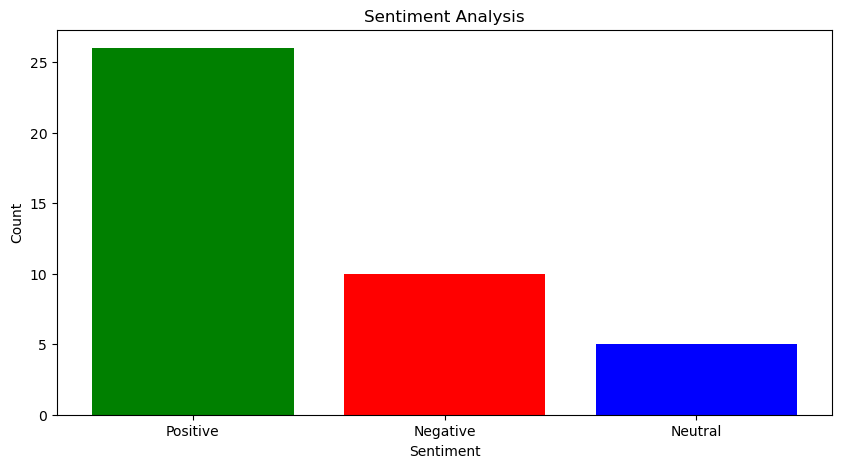

In [78]:
class SentimentAnalyzer:
    """
    A class to analyze sentiment from text content and summarize the results.
    """

    def analyze_sentiment(self, file_name="extracted_content.txt"):
        """
        Analyzes the sentiment of the text in the specified file.

        Parameters:
            file_name (str): The name of the file containing text to analyze. Defaults to 'extracted_content.txt'.
        """
        with open(file_name, 'r', encoding='utf-8') as file:
            content = file.read()  # Read the content of the file
            blob = TextBlob(content)  # Create a TextBlob object for sentiment analysis
            self.sentiment = blob.sentiment  # Get the sentiment of the content
            self.polarity = self.sentiment.polarity  # Extract polarity from sentiment
            self.subjectivity = self.sentiment.subjectivity  # Extract subjectivity from sentiment
            
            # Print sentiment results
            print(f"Sentiment Polarity: {self.sentiment.polarity}")  # Measure positivity or negativity
            print(f"Sentiment subjectivity: {self.sentiment.subjectivity}")  # Measure degree of opinion or objectivity

    def count_sentiments(self, paragraphs):
        """
        Counts the number of positive, negative, and neutral paragraphs.

        Parameters:
            paragraphs (list): A list of paragraphs to analyze.
        """
        self.positive = 0  # Initialize positive count
        self.negative = 0  # Initialize negative count
        self.neutral = 0   # Initialize neutral count
        self.total_paragraphs = len(paragraphs)  # Get total number of paragraphs

        for para in paragraphs:
            blob = TextBlob(para)  # Create a TextBlob object for each paragraph
            sentiment = blob.sentiment.polarity  # Get the polarity of the paragraph
            if sentiment > 0:
                self.positive += 1  # Increment positive count
            elif sentiment < 0:
                self.negative += 1  # Increment negative count
            else:
                self.neutral += 1  # Increment neutral count

        # Print counts of sentiments
        print(f"Number of positive: {self.positive}")
        print(f"Number of negative: {self.negative}")
        print(f"Number of neutral: {self.neutral}")

    def summarize_sentiment(self, paragraphs):
        """
        Summarizes sentiment analysis results and writes to a file.

        Parameters:
            paragraphs (list): A list of paragraphs to analyze.
        """
        self.count_sentiments(paragraphs)  # Count sentiments for the paragraphs
        self.analyze_sentiment()  # Analyze sentiment for the entire text
        
        # Write the summary of the sentiment analysis to a file
        with open("sentiment_summary.txt", 'w') as file:
            file.write("Sentiment Summary\n")  # Write header
            file.write(f"Total paragraphs: {self.total_paragraphs} \n")  # Write total paragraphs
            file.write(f"Number of positive: {self.positive}\n")  # Write positive count
            file.write(f"Number of negative: {self.negative}\n")  # Write negative count
            file.write(f"Number of neutral: {self.neutral} \n")  # Write neutral count
            file.write(f"Average sentiment polarity: {self.sentiment.polarity}\n")  # Write average polarity
            file.write(f"Average sentiment subjectivity: {self.sentiment.subjectivity}\n")  # Write average subjectivity

# Initialize and run sentiment analysis
sentiment_analyzer = SentimentAnalyzer()
sentiment_analyzer.analyze_sentiment()  # Analyze sentiment of the content
sentiment_analyzer.count_sentiments(cleaned_paragraphs)  # Count sentiments in cleaned paragraphs
sentiment_analyzer.summarize_sentiment(cleaned_paragraphs)  # Summarize sentiments

class Visualizer:
    """
    A class to visualize sentiment analysis results using bar plots.
    """

    def plot_sentiment(self, counts):
        """
        Plots the count of sentiments in a bar chart.

        Parameters:
            counts (list): A list containing counts of positive, negative, and neutral sentiments.
        """
        sentiment = ['Positive', 'Negative', 'Neutral']  # Labels for the sentiment categories
        plt.figure(figsize=(10, 5))  # Set figure size for the plot
        plt.bar(sentiment, counts, color=['green', 'red', 'blue'])  # Create a bar chart with specified colors
        plt.xlabel('Sentiment')  # Label for the x-axis
        plt.ylabel('Count')  # Label for the y-axis
        plt.title('Sentiment Analysis')  # Title of the plot
        plt.show()  # Display the plot

# Initialize and run visualization
visualizer = Visualizer()
visualizer.plot_sentiment([sentiment_analyzer.positive, sentiment_analyzer.negative, sentiment_analyzer.neutral])  # Plot sentiment counts


In [47]:
print("Sentiment analysis on aggregated content")
sentiment_analyzer = SentimentAnalyzer()
sentiment_analyzer.analyze_sentiment('aggregated content.txt')

Sentiment analysis on aggregated content
Sentiment Polarity: 0.16666666666666666
Sentiment subjectivity: 0.6405555555555555
